### Лабораторная работа №3. Исследование алгоритмов классификации

#### Постановка задачи
Выбрать атрибут, выступающий в роли целевого класса (метки)

Оценить сбалансированность классов;

Оценить и сравнить результаты классификации алгоритмами ***kNN***, ***Дерево решений***;

Сравнить результаты метриками оценки качества: ***Accuracy***, ***Precision***/***Recall***/***F1***, ***ROC***;

Объяснить полученные результаты, написать отчет с описанием выполнения каждой задачи.

In [1]:
import pandas as pd

# Plotting.
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing.
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Classifiers.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Metrics.
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score, roc_auc_score,
    precision_score, recall_score, f1_score
)

In [2]:
df = pd.read_csv(r'raw/loans/loans_clean.csv')
df.sample(10)

,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
3007,21,69566,527,0,2,0,8843,36,1,0,...,5797.166667,0.761744,5,11789,0.230343,0.221333,338.328316,0.096311,1,40.0
17095,18,32330,523,0,2,0,57780,120,1,1,...,2694.166667,0.467626,0,162850,0.351280,0.331503,1659.244707,0.946580,0,68.0
4621,60,104308,600,0,0,37,18868,36,0,2,...,8692.333333,0.804927,8,5701,0.203868,0.218030,718.655904,0.132031,1,37.6
19796,33,40631,554,1,2,10,28196,24,1,1,...,3385.916667,0.986977,6,73957,0.226196,0.236147,1485.337190,0.544118,0,60.0
7874,73,45710,618,2,1,54,17844,84,0,1,...,3809.166667,0.808443,4,52121,0.233844,0.248203,449.612770,0.278962,0,55.0
12467,45,41726,603,0,3,23,21935,48,2,2,...,3477.166667,0.767887,5,1132,0.215435,0.178611,642.749467,0.269688,0,54.0
6737,43,33836,524,2,1,18,19420,60,2,3,...,2819.666667,0.756793,5,57788,0.262420,0.281494,606.409558,0.472187,0,53.0
11376,39,30830,594,0,3,17,22524,48,2,1,...,2569.166667,0.742247,6,1593,0.220524,0.201680,687.431066,0.462185,0,59.0
7879,44,34735,508,1,3,18,20445,36,2,3,...,2894.583333,0.730342,7,221940,0.251445,0.274928,840.086264,0.457436,0,60.0
6922,45,44816,565,0,2,24,33545,12,0,1,...,3734.666667,0.761121,8,89295,0.216045,0.220432,3140.321286,0.936716,0,49.0


#### Выбор атрибута-метки
Набор данных является синтетическим примером данных, используемых для оценки кредитных рисков. Очевидно, что атрибут RiskScore является целевым для задач регрессии, а LoanApproved - меткой для классификации.

В первой работе категориальным признакам были присвоены числовые значения:
- EmploymentStatus: 'Employed': 0, 'Self-Employed': 1, 'Unemployed': 2
- EducationLevel: 'Master': 0, 'Associate': 1, 'Bachelor': 2, 'High School': 3, 'Doctorate': 4
- MaritalStatus: 'Married': 0, 'Single': 1, 'Divorced': 2, 'Widowed': 3
- HomeOwnershipStatus: 'Own': 0, 'Mortgage': 1, 'Rent': 2, 'Other': 3
- LoanPurpose: 'Home': 0, 'Debt Consolidation': 1, 'Education': 2, 'Other': 3, 'Auto': 4

Распределение классов для LoanApproved
0    15220
1     4780
Name: count, dtype: int64


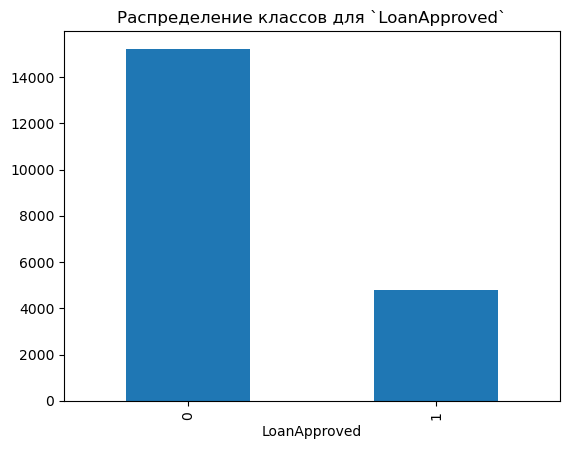

In [3]:
# Select target class.
target = 'LoanApproved'

# Check target class balance.
class_counts = df[target].value_counts()
print(f'Распределение классов для {class_counts}')
class_counts.plot(kind='bar', title=f'Распределение классов для `{target}`')
plt.show()

#### Балансировка
Видно, что одобренных кредитов меньше более чем в 3 раза.
Проверим два метода балансировки:
1. Under-sampling. Возьмём только 5000 примеров не одобренных кредитов. 
2. Over-sampling. С помощью imbalanced-learn.SMOTE увеличим количество одобренных кредитов в 3 раза.
Также возьмём изначальный набор, чтобы наглядно увидеть улучшение результатов классификации.

In [4]:
# Under sampling.
df_under_sampled = pd.concat([
    df[df[target] == 0].sample(n=5000, random_state=0),
    df[df[target] == 1]
])

In [5]:
# Over sampling.
smote = SMOTE(random_state=0)
x = df.drop(target, axis=1)
y = df[target]
x_smote, y_smote = smote.fit_resample(x, y)
df_over_sampled = pd.concat([pd.DataFrame(x_smote), pd.DataFrame(y_smote, columns=[target])], axis=1)

#### K Nearest Neighbors

In [6]:
def show_metrics(y_test, y_pred):
    """Display confusion matrix and metrics (accuracy, precision, recall, f1, roc)."""
    # Confusion matrix plot.
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Compute metrics.
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    roc = round(roc_auc_score(y_test, y_pred), 3)
    
    # Show metrics as table.
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC'],
        'Score': [accuracy, precision, recall, f1, roc]
    })
    print(metrics_df.to_string(index=False))

In [7]:
def get_best_k(x_train, y_train, x_test, y_test, max_k) -> int:
    """Compare accuracy for different k-value with visualization."""
    # Get accuracy for different number of neighbors.
    scores_by_neighbors = []
    for k in range(1, max_k+1):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train)
        knn_pred = knn.predict(x_test)
        score = accuracy_score(y_test, knn_pred)
        scores_by_neighbors.append(score)
        
    # Plotting accuracy for different number of neighbors.
    plt.plot(
        range(1, max_k+1), scores_by_neighbors, 
        linestyle='dashed', marker='o'
    )
    plt.xticks(range(0, max_k+1, 2))
    plt.title("Accuracy vs k-value")
    plt.xlabel("k")
    plt.ylabel('Accuracy')
    plt.show()
    
    # Return best k-value.
    best_k = scores_by_neighbors.index(max(scores_by_neighbors)) + 1
    return best_k

In [8]:
def get_knn(x_train, y_train, x_test, y_test, k_max) -> KNeighborsClassifier:
    """Return KNN classifier with best k-value for given train and test sets."""
    k = get_best_k(x_train, y_train, x_test, y_test, k_max)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    knn_pred = knn.predict(x_test)
    
    print(f'KNN with k={k} results:')
    show_metrics(y_test, knn_pred)
    
    return knn

In [9]:
def df_to_knn(dataframe: pd.DataFrame, target_name: str, k_max: int) -> KNeighborsClassifier:
    """Split dataframe into train and test sets and return KNN classifier with best k-value."""
    x_train, x_test, y_train, y_test = train_test_split(
        dataframe.drop(target_name, axis=1), 
        dataframe[target_name],
        test_size=0.2,
        random_state=0
    )
    return get_knn(x_train, y_train, x_test, y_test, k_max)

KNN for not balanced DF (shape: (20000, 35))


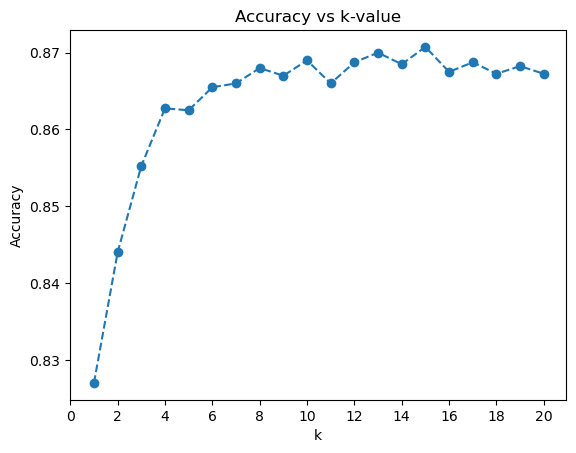

KNN with k=15 results:


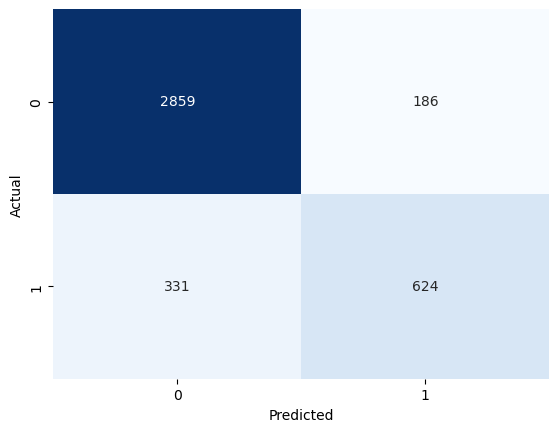

   Metric  Score
 Accuracy  0.871
Precision  0.770
   Recall  0.653
       F1  0.707
      ROC  0.796


KNN for under-sampled DF (shape: (9780, 35))


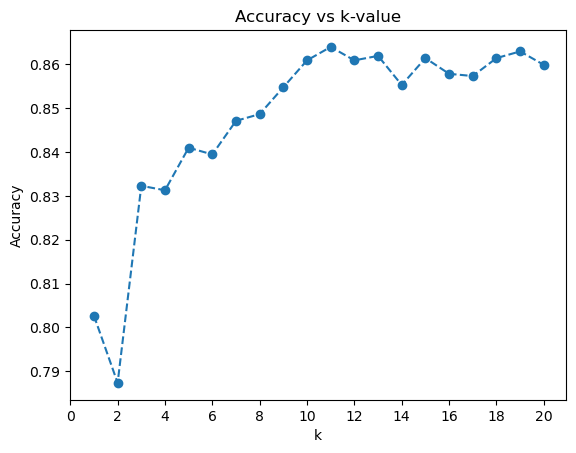

KNN with k=11 results:


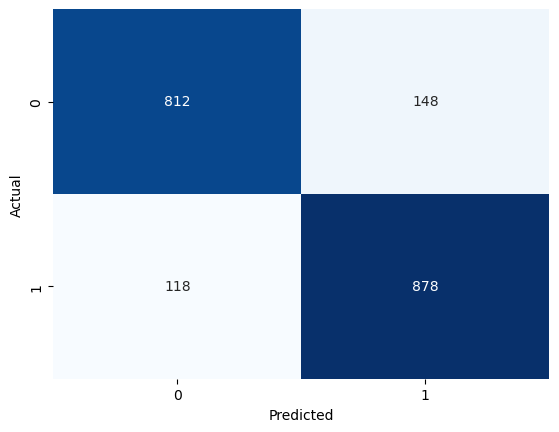

   Metric  Score
 Accuracy  0.864
Precision  0.856
   Recall  0.882
       F1  0.868
      ROC  0.864


KNN for over-sampled DF (shape: (30440, 35))


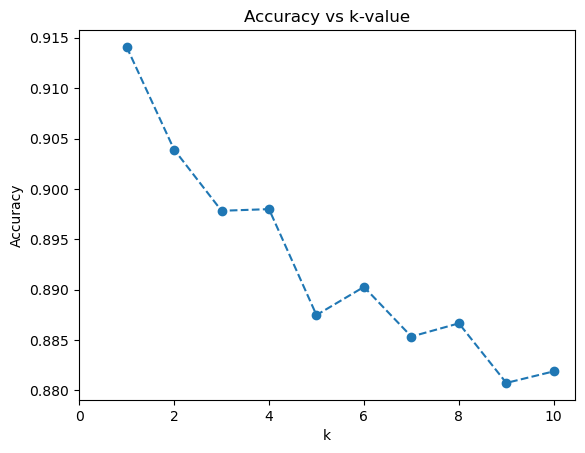

KNN with k=1 results:


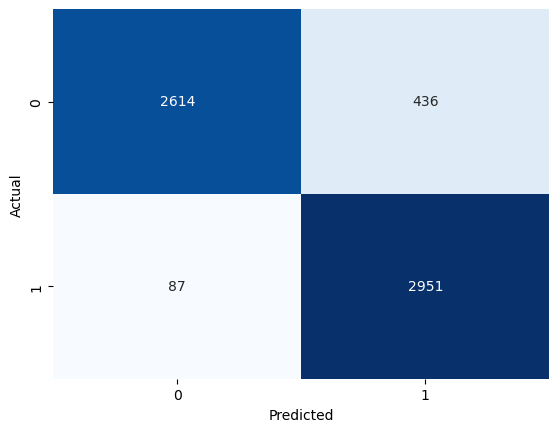

   Metric  Score
 Accuracy  0.914
Precision  0.871
   Recall  0.971
       F1  0.919
      ROC  0.914



In [10]:
print(f'KNN for not balanced DF (shape: {df.shape})')
df_to_knn(df, target, k_max=20)

print(f'\n\nKNN for under-sampled DF (shape: {df_under_sampled.shape})')
df_to_knn(df_under_sampled, target, k_max=20)

print(f'\n\nKNN for over-sampled DF (shape: {df_over_sampled.shape})')
df_to_knn(df_over_sampled, target, k_max=10)

print()

#### Decision Tree

In [11]:
def get_dt(x_train, y_train, x_test, y_test):
    """Return Decision Tree classifier for given train and test sets."""
    dt = DecisionTreeClassifier()
    dt.fit(x_train, y_train)
    dt_pred = dt.predict(x_test)

    print(f'Decision Tree results:')
    show_metrics(y_test, dt_pred)

    return dt

In [12]:
def df_to_dt(dataframe: pd.DataFrame, target_name: str) -> DecisionTreeClassifier:
    """Split dataframe into train and test sets and return KNN classifier with best k-value."""
    x_train, x_test, y_train, y_test = train_test_split(
        dataframe.drop(target_name, axis=1), 
        dataframe[target_name],
        test_size=0.2,
        random_state=0
    )
    return get_dt(x_train, y_train, x_test, y_test)

DT for not balanced DF (shape: (20000, 35))
Decision Tree results:


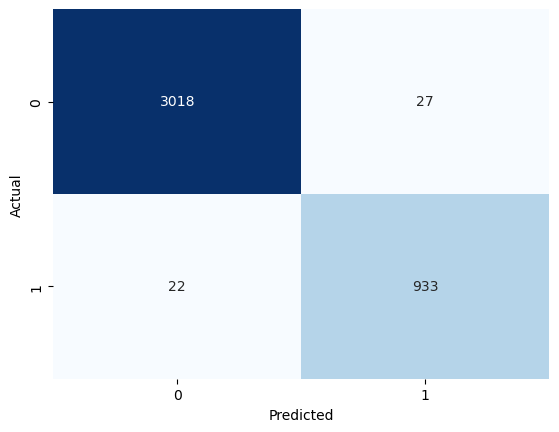

   Metric  Score
 Accuracy  0.988
Precision  0.972
   Recall  0.977
       F1  0.974
      ROC  0.984


DT for under-sampled DF (shape: (9780, 35))
Decision Tree results:


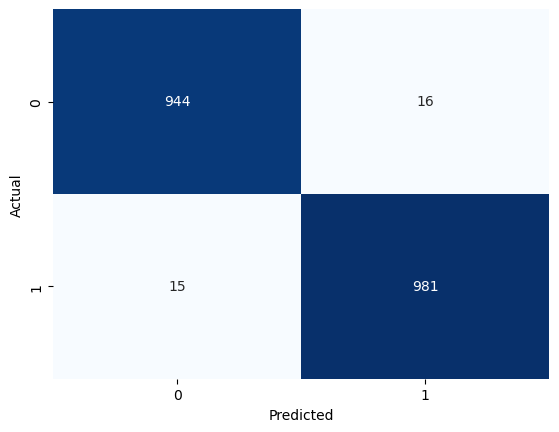

   Metric  Score
 Accuracy  0.984
Precision  0.984
   Recall  0.985
       F1  0.984
      ROC  0.984


DT for over-sampled DF (shape: (30440, 35))
Decision Tree results:


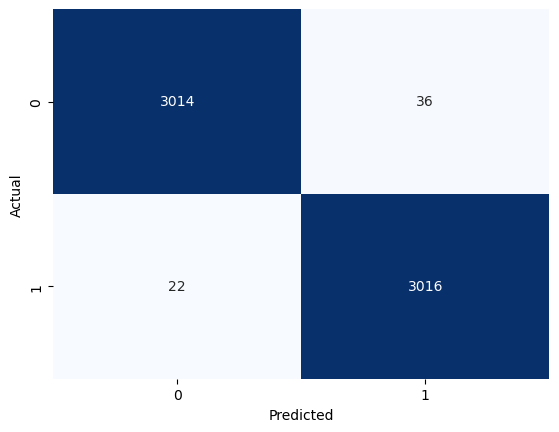

   Metric  Score
 Accuracy  0.990
Precision  0.988
   Recall  0.993
       F1  0.990
      ROC  0.990



In [13]:
print(f'DT for not balanced DF (shape: {df.shape})')
df_to_dt(df, target)

print(f'\n\nDT for under-sampled DF (shape: {df_under_sampled.shape})')
df_to_dt(df_under_sampled, target)

print(f'\n\nDT for over-sampled DF (shape: {df_over_sampled.shape})')
df_to_dt(df_over_sampled, target)

print()

#### Анализ результатов
Сокращения в таблице: 
- NB - not balanced
- US - under-sampled
- OS - over-sampled
- KNN - K Nearest Neighbors
- DT - Decision Tree

|           | NB KNN | US KNN | OS KNN | NB DT | US DT | OS DT |
|-----------|--------|--------|--------|-------|-------|-------|
| accuracy  | 0.871  | 0.864  | 0.914  | 0.987 | 0.984 | 0.992 |
| precision | 0.770  | 0.856  | 0.871  | 0.973 | 0.984 | 0.991 |
| recall    | 0.653  | 0.882  | 0.971  | 0.973 | 0.985 | 0.992 |
| f1        | 0.707  | 0.868  | 0.919  | 0.973 | 0.984 | 0.992 |
| roc       | 0.796  | 0.864  | 0.914  | 0.982 | 0.984 | 0.992 |

На основе полученных результатов можно сделать выводы:
- Для данного набора данных классификация деревом решений показывает лучший результат как по сравнению с KNN, так и в общем. Итог ожидаемый, ведь деревья решений хорошо справляются с бинарными метками и являются классическим примером для решения задач одобрения кредитов.
- Результаты accuracy для несбалансированных данных хорошо отражают причину недостаточности этой метрики. Для NB KNN accuracy = 0.871, хотя более точные метрики показывают результат на 10-20% ниже. Это подчеркивает важность использования разных метрик для качественного анализа результатов модели.
- Over-sampling методом SMOTE показало наилучшие результаты, ведь изначальный объем данных не слишком велик.
- Для KNN и DT, как для зависимых от балансировки методов, любая балансировка, даже простой under-sampling, улучшает результаты. 
